# Data Augmentation I

**Date**: Thursday Sept 12, 2024

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/11-data-augmentation-mcmc-1.ipynb)




## LEARNING OUTCOMES

* Understand how to fit epidemic models to censored/unobserved event data
* Understand how the move events algorithm works
* Implement a move algorithm in Python and conduct inference on missing infection times

## Outline


Generally, outbreak data only captures a partially observed epidemic process. As there are time-dependent quantities in the likelihood we cannot evaluate it with missing event times. One way of tackling censored data is to use a likelihood free method of conducting inference (such as ABC).

Alternatively, we can try to augment the data to estimate the unobserved epidemiological event times. In a Bayesian setting we can simply treat missing event (transition) times as parameters to be estimated.

A fully observed epidemic at a metapopulation level, would mean we know how many units experienced an event at each time point.

At an individual level, the time of each of their epidemic events (transitions between states) would be recorded. This might look something like this:



In [1]:
# @title
import numpy as np
import pandas as pd

unit_id = np.arange(0,10)
infection_times = np.random.randint(low=1, high=20, size=10).astype(np.float32)
removal_times = np.random.randint(low=1, high=20, size=10).astype(np.float32)

line_list = pd.DataFrame({'unit_id': unit_id,
                        'SI transition time': infection_times,
                        'IR transition time': removal_times}
                        ).set_index('unit_id')
line_list

,SI transition time,IR transition time
unit_id,,
0,5.0,15.0
1,8.0,9.0
2,15.0,9.0
3,12.0,16.0
4,18.0,11.0
5,7.0,16.0
6,1.0,8.0
7,1.0,9.0
8,2.0,5.0


Whereas data from a partially observed epidemic, with missing infection times for example, would look more like this:


In [2]:
# @title
unobserved_infection_times = np.nan

censored_line_list =pd.DataFrame({'unit_id': unit_id,
                        'SI transition time': unobserved_infection_times,
                        'IR transition time': removal_times}
                        ).set_index('unit_id')
censored_line_list

,SI transition time,IR transition time
unit_id,,
0,NaN,15.0
1,NaN,9.0
2,NaN,9.0
3,NaN,16.0
4,NaN,11.0
5,NaN,16.0
6,NaN,8.0
7,NaN,9.0
8,NaN,5.0


This morning, we will think about how we can estimate missing infection times by adding them as parameters to a MCMC algorithm.

## Move algorithm

The move algorithm allows for jittering of event times. If we were modelling SARS-CoV-2, a likely set of infection data may be positive test results. We could assume that from the testing dataset we know which individuals were infected. However, the testing data would not provide the time that inidividuals were initially infected. We could therefore provide some initial infection times for each individual who tested positive and use a move algorithm to estimate their SI transition event (infection time).

The move algorithm for a discrete-time SIR model is as follows:



**Algorithm:** Move events algorithm.

>**Input:** $q(\cdot)$ proposal distribution, $\pi(\cdot)$ a target distribution \\

>**Initialise:** $z^{0}$


1. Choose an event, time *t* and unit *i*, to move:

$$t, i \sim U\{t, i: z_{it}>0\}$$

2. Choose a time delta for the event move:

 $$\delta \sim U[1, \delta_{max}]$$

3. Update event time. Let:

$$z_{it}^* = z_{it} -1$$

$$z_{it + \delta}^* = z_{it + \delta} + 1$$


4. Compute

$$\alpha(z, z^*) = 1 \wedge \frac{\pi(z^* | \cdot)q(z | z*)}{\pi(z | \cdot)q(z^*|z)}$$

As we are using a symmetric proposal for the event moves, the q ratio cancels. i.e. $||z_{it}^* > 0|| = ||z_{it} > 0||$


### Define an individual-level SIR model in gemlib to condition on.

In [ ]:
from warnings import warn

try:
    import google.colab
    !pip install gemlib
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from typing import NamedTuple

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
from gemlib.distributions import DiscreteTimeStateTransitionModel

tfd = tfp.distributions

%matplotlib inline

DTYPE=np.float32

In [5]:
# Defining epidemic model parameters
popsize = 50

initial_state = np.concatenate(
    [
        [[0, 1, 0]], # Initial infected
        np.repeat([[1, 0, 0]], popsize-1, axis=0) # Everybody else susceptible
    ],
    axis=0,
).astype(DTYPE)

incidence_matrix = np.array(
    [ #  SI  IR
        [-1,  0],  # S
        [ 1, -1],  # I
        [ 0,  1], # R
    ],
    dtype=DTYPE
  )

In [6]:
# define as a Bayesian model
@tfd.JointDistributionCoroutine
def model():

  # Prior
  beta = yield tfd.Gamma(
      concentration=DTYPE(0.5), rate=DTYPE(2.0), name="beta",
  )

  def transition_rates(t, state):
    epsilon = DTYPE(0.001)
    gamma = DTYPE(0.02)

    num_infected = tf.reduce_sum(state[:,1])
    si_rate = (tf.ones_like(initial_state[:,0]) * beta * num_infected/popsize) + epsilon

    ir_rate = tf.fill((state.shape[0],), gamma)

    return si_rate, ir_rate

  sir =  yield DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                      incidence_matrix=incidence_matrix,
                                      initial_state=initial_state,
                                      initial_step=0,
                                      time_delta=1.0,
                                      num_steps=50,
                                      name ="sir")

In [ ]:
# simulate from the epidemic model to provide inital event times for fitting
beta_val, sir_val= model.sample(seed=[0,1])
event_list = np.array(sir_val)

# condition a model on beta - we'll use this for our tlp function later
conditioned_model = model.experimental_pin(beta=0.5)

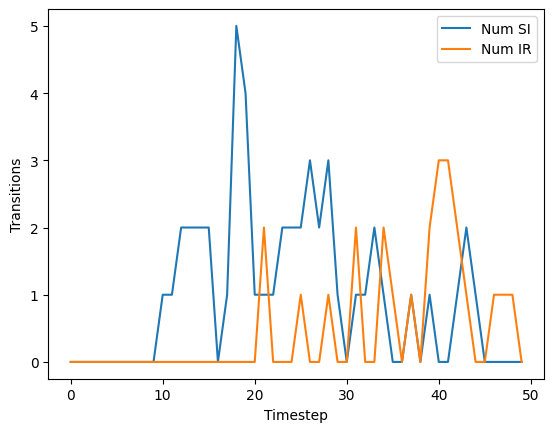

In [8]:
plt.plot(np.sum(sir_val, axis=1), label=["Num SI", "Num IR"])
plt.xlabel("Timestep")
plt.ylabel("Transitions")
plt.legend()

### Exercise 1 - Code a move algorithm for infection times

1. Using the simulated epidemic output above, try to move an event time in event_list.

> You can copy the code outline below as a guide to coding your own move algorithm. Alternatively, take another look at the algorithm definition, try it your own way and compare with the solution at the end.

```
import random

# Let's start by only moving one event with a maximum time delta of 2
num_moves = 1
delta_max = 2

# Firstly, locate the index positions for the SI events in event_list
# [T, N metapopulations, L transitions]. e.g. non-zero entries for the SI transition
# try using np.where

valid_events =

# Choose which of these events to move. One option is to use random.sample
index_events_to_move =

# we can access the current value of the event we want to move.
# print event_list at the index position for the chosen event move
print()

# create a variable which indicates the direction of the move (forward or backwards).
# we can use np.random.choice to do this.

event_direction =

# draw a time delta for the move (e.g. number of time steps into future/past)
# we can use np.random.randint to do this

time_delta =

# we now update the event time if the new time appears in our time interval
if ():
    
      # remove the event that we are moving from the event list (-1)
      
      # add the event at the new time point (+1)
     
```



### Solution

In [20]:
# @title
import random

# Let's start by only moving one transition event with a maximum time delta of 2
num_moves = 1
delta_max = 2

# locate the index positions for the SI events in event_list [T, N metapopulations, L transitions]
# try using np.where
valid_events = np.where(event_list[:,:,0]>0)

# choose which of these events to move. One option is to use random.sample
index_events_to_move = random.sample(range(0, valid_events[0].shape[0]),
                                    num_moves)

In [17]:
# @title
# we can access the current value of the event we want to move.
# print event_list at the index position for the chosen event move
print(event_list[valid_events[0][index_events_to_move[0]], valid_events[1][index_events_to_move[0]],0])

1.0


In [18]:
# @title
# create a variable which indicates the direction of the move (forward or backwards)
event_direction = np.random.choice(np.array([-1, 1]))

# define a time delta for the move (e.g. number of time steps into future/past)
time_delta = np.random.randint(1, delta_max, size = 1)

# calculate time to move the event to
updated_time_index = valid_events[0][index_events_to_move[0]] + time_delta * event_direction

# we now update the event time if the new time appears in our time interval
if (updated_time_index >= 0) and (updated_time_index <= event_list.shape[0] -1):

  # remove the event that we are moving from the event list (-1)
  event_list[valid_events[0][index_events_to_move[0]], valid_events[1][index_events_to_move[0]],0] -= 1

  # add the event at the new time point (+1)
  event_list[updated_time_index, valid_events[1][index_events_to_move[0]], 0] += 1

In [19]:
# @title
# check that our event has been removed from the original timepoint
print(event_list[valid_events[0][index_events_to_move[0]], valid_events[1][index_events_to_move[0]],0])

0.0


## Advanced exercise:
Check whether your algorithm would work for a metapopulation model. If it doesn't, what do you need to change?

### Embed the move events algorithm within our Metropolis-Hastings algorithm

To use the move algorithm within our Metropolis Algorithm (which we coded yesterday) let's define it as a function

In [21]:
def move_event_time(event_list, num_changes=1, delta_max=2):

    # locate the index positions for the SI events in event_list
    valid_events = np.where(event_list[:,:,0] >0)

    # choose which of these events to move
    index_events_to_move = random.sample(range(0, valid_events[0].shape[0]),
                                        num_changes)

    # direction of the move
    move_direction = np.random.choice(np.array([-1, 1]))

    # define a time delta for the move (e.g. number of time steps into future/past)
    time_delta = np.random.randint(1, delta_max, size = 1)

    # calculate time to move the event to
    updated_time_index = valid_events[0][index_events_to_move[0]] + time_delta * event_direction

    # we now update the event time if the new time appears in our time interval
    if (updated_time_index >= 0) and (updated_time_index <= event_list.shape[0] -1):

      # remove the event that we are moving from the event list (-1)
      event_list[valid_events[0][index_events_to_move[0]], valid_events[1][index_events_to_move[0]],0] -= 1

      # add the event at the new time point (+1)
      event_list[updated_time_index, valid_events[1][index_events_to_move[0]], 0] += 1

    return event_list



## Exercise 2:
The functions needed for the Metropolis-Hastings algorithm have been defined below, using yesterday's format.

1. Set the proposal distribution to call `move_event_time`. Setting num_changes =` and delta_max = 2
2. Keep track of the proposed_log_prob values as well as `samples` and `accept`
3. Plot the event times using matplotlib.pyplot.imshow (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
4. What happens to the proposed_log_prob if you increase num_changes and/or delta_max?


**Copy these functions to get you started:**
```
def mh_accept(proposed_log_prob, current_log_prob, log_q_ratio):
  """Decides whether to accept or reject a MH move"""
  acceptance_prob = proposed_log_prob - current_log_prob
  u = tfd.Bernoulli(probs=acceptance_prob, dtype=tf.bool).sample()
  return u
```

```
def target_log_prob_fn(sir_val):
    return conditioned_model.log_prob(sir=sir_val)
```

```
def mh_algo_events(
    target_log_prob_fn,
    init_state,
    num_samples,
):

    samples = []
    accept = []

    #set current state and compute log prob
    current_state = np.array(init_state)
    current_log_prob = target_log_prob_fn(current_state)

    for i in range(num_samples):
      # Compute current likelihood
      current_log_prob = target_log_prob_fn(current_state)

      proposed_state =  # ADD proposed state

      # Compute proposed log likelihood
      proposed_log_prob = target_log_prob_fn(proposed_state)

      log_q_ratio = 0.0 # move_event_times uses a symmetric proposal

      # Calculate acceptance probabiliy and update parameter and posterior value
      is_accepted = mh_accept(
          proposed_log_prob,
          current_log_prob,
          log_q_ratio
      )
      if is_accepted:
        current_state = proposed_state

      samples.append(current_state)
      accept.append(is_accepted)

    return np.stack(samples, axis=0), np.stack(accept, axis=0)
```

```
#run the MCMC
num_samples = 10

samples, accept = mh_algo_events(target_log_prob_fn=target_log_prob_fn,
    init_state=model.sample(beta = 0.05).sir,
    num_samples=num_samples)
```



### Solutions to exercise 2

In [22]:
# @title
def mh_accept(proposed_log_prob, current_log_prob, log_q_ratio):
  """Decides whether to accept or reject a MH move"""
  acceptance_prob = proposed_log_prob - current_log_prob
  u = tfd.Bernoulli(probs=acceptance_prob, dtype=tf.bool).sample()
  return u

In [23]:
# @title
def target_log_prob_fn(sir_val):
    return conditioned_model.log_prob(sir=sir_val)

In [24]:
# @title
def mh_algo_events(
    target_log_prob_fn,
    init_state,
    num_samples,
):

    samples = []
    accept = []
    proposed_tlp = []


    #set current state and compute log prob
    current_state = np.array(init_state)
    current_log_prob = target_log_prob_fn(current_state)

    for i in range(num_samples):
      # Compute current likelihood
      current_log_prob = target_log_prob_fn(current_state)

      # Draw proposed state
      proposed_state = move_event_time(event_list = current_state,
                                        num_changes = 1,
                                        delta_max = 2
                                        )
      # Compute proposed log likelihood
      proposed_log_prob = target_log_prob_fn(proposed_state)

      log_q_ratio = 0.0 # move_event_times uses a symmetric proposal

      # Calculate acceptance probabiliy and update parameter and posterior value
      is_accepted = mh_accept(
          proposed_log_prob,
          current_log_prob,
          log_q_ratio
      )
      if is_accepted:
        current_state = proposed_state

      samples.append(current_state)
      accept.append(is_accepted)
      proposed_tlp.append(proposed_log_prob)

    return np.stack(samples, axis=0), np.stack(accept, axis=0), np.stack(proposed_tlp, axis=0)

In [ ]:
# @title
num_samples = 25

samples, accept, proposed_tlps = mh_algo_events(target_log_prob_fn=target_log_prob_fn,
    init_state=model.sample(beta = 0.2, seed=[1,2]).sir,
    num_samples=num_samples)

In [26]:
# @title
print('proposed log pobs: ', proposed_tlps)

proposed log pobs:  [-311.3518  -311.4371  -311.71405 -311.22504 -310.85446 -310.7799
 -311.046   -311.20923 -311.2647  -311.18106 -311.15784 -311.48895
 -311.805   -311.70746 -311.732   -311.99896 -312.00476 -311.7926
 -311.83356 -311.96097 -312.12088 -312.48975 -312.77982 -312.8463
 -312.65063]


In [27]:
# @title
# calculate the acceptance rate
np.sum(accept)/num_samples

0.08